In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import plotly.graph_objects as go
from matplotlib.sankey import Sankey
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings("ignore")


In [23]:
#Load the Excel File
data = pd.ExcelFile('V02Max_Combined.xlsx')
#Get the sheet names
sheet = data.sheet_names
print('Sheet Names:',sheet)

#Read each sheet 
data_Kayaking = pd.read_excel(data,sheet_name = 'Kayaking')
data_Athletes = pd.read_excel(data, sheet_name = 'Athletes')
data_Triathlon = pd.read_excel(data,sheet_name =  'Triathlon')
data_Fencing = pd.read_excel(data,sheet_name =  'Fencing')

#verify dataframes
print(data_Kayaking.head())
print(data_Athletes.head())
print(data_Triathlon.head())
print(data_Fencing.head())

Sheet Names: ['Kayaking', 'Athletes', 'Triathlon', 'Fencing']
   ID     time     RR       VO2  power
0  11 -168.600  727.0  0.287147      0
1  11 -167.872  728.0  0.287147      0
2  11 -167.148  724.0  0.287147      0
3  11 -166.484  664.0  0.320580      0
4  11 -165.836  648.0  0.320580      0
   ID  age  Weight  Height  P_vt1  P_vt2    sport  Gender Ethnicity  \
0   1   15    53.7     161     50    140  fencing  Female   African   
1   2   15    56.2     162     80    127  fencing    Male   African   
2   3   16    89.9     191    155    300  fencing    Male     White   
3   4   16    76.5     180    215    275  fencing    Male     White   
4   5   17    76.4     186    110    172  fencing  Female     White   

  First Name Last Name  
0     Olivia  Martinez  
1      Ethan  Reynolds  
2    Jackson    Harper  
3       Liam   Sanchez  
4        Ava  Thompson  
   ID     time     RR       VO2  power
0  17 -182.408  736.0  0.363762      0
1  17 -181.672  736.0  0.363762      0
2  17 -180

In [15]:
#Load the Excel File
data_merged = pd.ExcelFile('merged_athletes_data.xlsx')
#Get the sheet names
merged_sheet = data_merged.sheet_names
#print('Sheet Names:',merged_sheet)
data_merged_sheet= pd.read_excel(data_merged,sheet_name = 'Sheet1')
print(data_merged_sheet.head())


   ID     time     RR       VO2  power
0  11 -168.600  727.0  0.287147      0
1  11 -167.872  728.0  0.287147      0
2  11 -167.148  724.0  0.287147      0
3  11 -166.484  664.0  0.320580      0
4  11 -165.836  648.0  0.320580      0


21.Display a pie chart of number of athletes by sport.

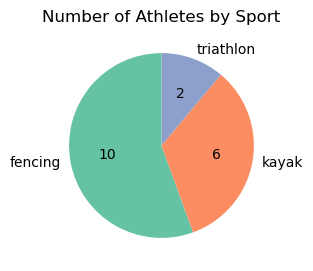

In [188]:
#Count the Athletes by Sport by accessing the sport column in Data Atheletes Data frame
count=data_Athletes['sport'].value_counts()
#Create figure with size 4*3 inches
plt.figure(figsize=(4, 3))
#Create pie chart and format the labels to two decimal points
labels_sport=data_Athletes['sport'].unique()

plt.pie(count, 
        labels=labels_sport,
        labeldistance=1.1,
        autopct=lambda x: '{:.0f}'.format(x * (data_Athletes['sport'].count()) / 100),
        textprops={'fontsize':10},
        colors=sns.color_palette('Set2'),
        startangle=90)
#Adds a title
plt.title('Number of Athletes by Sport')
#Displays Pie chart
plt.show()

22.Using any 10 HR values print even if the value is an even number and odd if its an odd number

In [68]:

#RR=data_Triathlon['RR'][:10]
#Random 10 values from RR column
RR=data_Triathlon['RR'].sample(n=10,random_state=1)
#Heart Rate for every Random RR value
HR=[60/(RR/1000) for RR in RR]

#checking each iterable value odd or even
for i in HR:
    if i%2==0:
        #Format using string literal values with 2 decimal point and printing odd or even status
        print(f"{i:.2f} : even")
      
    else:
        print(f"{i:.2f} : odd")


131.58 : odd
127.12 : odd
166.67 : odd
137.61 : odd
132.74 : odd
126.05 : odd
82.42 : odd
132.74 : odd
142.86 : odd
150.00 : even


In [ ]:
23. Which heart rate zone did most participants spend the longest duration of time in?

In [190]:
#zone_sport=data_Athletes['sport','Ethnicity']
zone_sport=data_Athletes['sport']
zone_ethnicity=data_Athletes['Ethnicity']
RR=data_Triathlon['RR']
HR=[60/(RR/1000) for RR in RR]


24.Store athlete name and sport in a dictionary as a pair of values.

In [96]:
#creating dictionary
athelete_sport_dict=data_Athletes.set_index(data_Athletes['First Name']+ ' '+data_Athletes['Last Name']).to_dict('dict')['sport']
#verifying the created dictionary
print(athelete_sport_dict)

{'Olivia Martinez': 'fencing', 'Ethan Reynolds': 'fencing', 'Jackson Harper': 'fencing', 'Liam Sanchez': 'fencing', 'Ava Thompson': 'fencing', 'Sophia Rodriguez': 'fencing', 'Grace Simmons': 'fencing', 'Aiden Bennett': 'fencing', 'Chloe Price': 'fencing', 'Lily Jordan': 'fencing', 'Isabella Griffin': 'kayak', 'Caleb Dixon': 'kayak', 'Mia Carpenter': 'kayak', 'Harper Mitchell': 'kayak', 'Mason Wallace': 'kayak', 'Logan Anderson': 'kayak', 'Lucas Foster': 'triathlon', 'Owen Myers': 'triathlon'}


In [ ]:
25. Using arrays and loops, find the count of athletes based on gender.

In [348]:
male_counter=0
female_counter=0
gen_array=data_Athletes['Gender'].values
print(type(gen_array))
for i in gen_array:
    if i =='Female':
        female_counter = female_counter+1             
    else:
        male_counter = male_counter+1
        
print('No of athletes in Female Categry:',female_counter)
print('No of athletes in Male Categry:',male_counter)

<class 'numpy.ndarray'>
No of athletes in Female Categry: 10
No of athletes in Male Categry: 8


26.Create a sankey diagram to show the groups of race within each sport

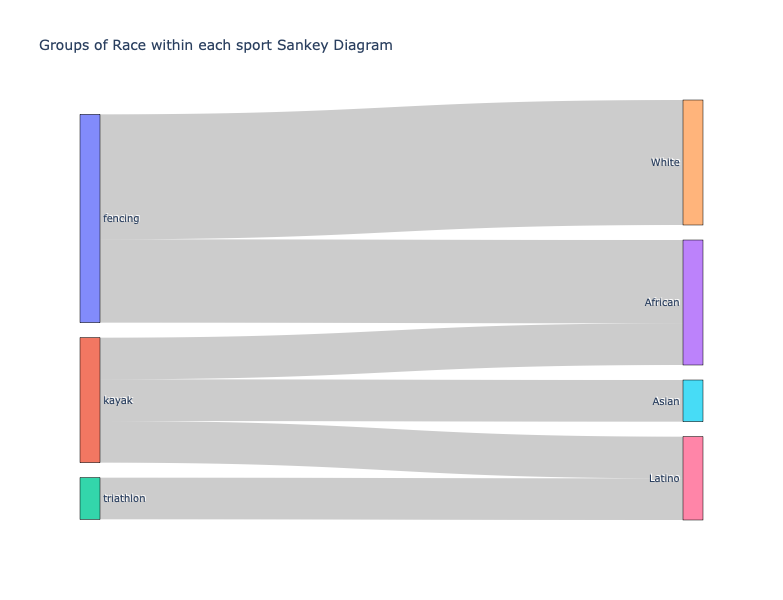

In [300]:
sport_group=data_Athletes['sport'].unique()

race_group=data_Athletes['Ethnicity'].unique()

sport_race_group=data_Athletes.groupby(['sport', 'Ethnicity']).size().reset_index(name='count')

sport_race_group.columns=['source','target','value']


unique_source_target_values = list(pd.unique(sport_race_group[['source', 'target']].values.ravel('K')))


#for assigning unique number to each source and target
mapping_dictionary = {k: v for v, k in enumerate(unique_source_target_values)}


#mapping of full data
sport_race_group['source']=sport_race_group['source'].map(mapping_dictionary)

sport_race_group['target']=sport_race_group['target'].map(mapping_dictionary)


#converting full dataframe as list for using with in plotly
links_dict = sport_race_group.to_dict(orient='list')

#Sankey Diagram 
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label =unique_source_target_values,      
    ),
    link = dict(
      source = links_dict["source"],
      target = links_dict["target"],
      value = links_dict["value"],
  
  ))])
fig.update_layout(title_text="Groups of Race within each sport Sankey Diagram", font_size=10,width=1000, height=600)
fig.show()



27.Calculate the average heart rate for every minute for every athlete and add it as a column in the same dataframe.

In [ ]:
28.Print athlete 15s Age and Pvt1 using the format() function

In [324]:
athlete_15_data=data_Athletes[data_Athletes['ID']==15].iloc[0]
#print(athlete_15_data)
athelete_age=athlete_15_data['age']
#print(athelete_age)
athelete_p_vt1=athlete_15_data['P_vt1']
#print(athelete_p_vt1)
print("Athelete ID 15 : Age {}, P_vt1 {}".format(athelete_age,athelete_p_vt1))

Athelete ID 15 : Age 13, P_vt1 125


29.On average how long was each participants’ warm up?

30.Display the HRV of each athlete?

31.Return the count of athletes for any sport that the user inputs.

In [43]:
def count_athlete(sport):
   
    data_sport=data_Athletes[data_Athletes['sport'].str.lower()==sport.lower()]
    return data_sport.shape[0]

sport=str(input('Enter the Sport Name : '))

count=count_athlete(sport)

print(sport,count)

Enter the Sport Name :  triathlon


triathlon 2


In [ ]:
32.Insert the name of every athlete into an array and display the length of that array.

In [45]:
data_Athletes['Full Name'] = data_Athletes['First Name'].fillna('') + ' ' + data_Athletes['Last Name'].fillna('')

athlete_names = data_Athletes['Full Name'].tolist()

athlete_names_array = np.array(athlete_names)
print("Number of athletes:", len(athlete_names_array))

Number of athletes: 18


In [ ]:
33.Create a list and a tuple. Print the types and lengths of  both.

In [342]:
list=[1,'hello',55.4,100,[2,3,4],5,3,['venba'],(3,5,6),45,33.33]
print(list)
tuple=(3,5,'hi',33.5,3,6,7,8,222,['hi',3,0],55,88,99,0.5)
print(tuple)
print('list Type : ',type(list))
print('Tuple Type : ',type(tuple))
print('list Type : ',len(list))
print('Tuple Type : ',len(tuple))

[1, 'hello', 55.4, 100, [2, 3, 4], 5, 3, ['venba'], (3, 5, 6), 45, 33.33]
(3, 5, 'hi', 33.5, 3, 6, 7, 8, 222, ['hi', 3, 0], 55, 88, 99, 0.5)
list Type :  <class 'list'>
Tuple Type :  <class 'tuple'>
list Type :  11
Tuple Type :  14


34.Display a word cloud using any values in the dataset

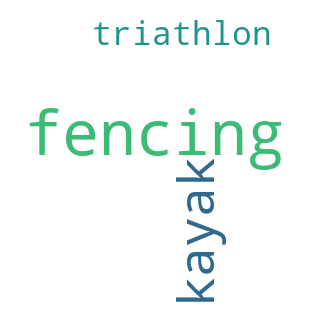

In [25]:
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in data_Athletes.sport:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 300, height = 300,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                       
plt.figure(figsize = (3, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

35.Create a Regression Plot on Max V02 and mean BMI for any sport of your choice

36.Plot the time series of HR( every 5 mins) of athlete 1

37.What was the maximum power achieved in terms of watts,
which participant achieved it? Display name, sport and watts.

38.What is the average  difference in IBI during the warm up Vs the actual test?

39.Print out what's in indexes 7, 10, and 3 for the array in Q33.

In [344]:
list_items=[list[i] for i in [7,10,3]]
tupple_items=[tuple[i] for i in [7,10,3]]
print('list items : ',list_items)
print('tuple items: ',tupple_items)

list items :  [['venba'], 33.33, 100]
tuple items:  [8, 55, 33.5]


40.     [ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25],
       [26, 27, 28, 29, 30]  Use array slicing to display elements 1,3,5. If the value is less than 4 display it as 99

In [354]:
array = np.array([
    [1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10],
    [11, 12, 13, 14, 15],
    [16, 17, 18, 19, 20],
    [21, 22, 23, 24, 25],
    [26, 27, 28, 29, 30]
])

var=[]

for row in array:
    extract_elements=[row[i] if i <len(row) else None for i in [1,3,4]]
    extract_elements=[99 if j is not None and j<4 else j for j in extract_elements]
    var.append(extract_elements)


for k,n in enumerate(var):
    print(f"Row{k}:{n}")
    


Row0:[99, 4, 5]
Row1:[7, 9, 10]
Row2:[12, 14, 15]
Row3:[17, 19, 20]
Row4:[22, 24, 25]
Row5:[27, 29, 30]
